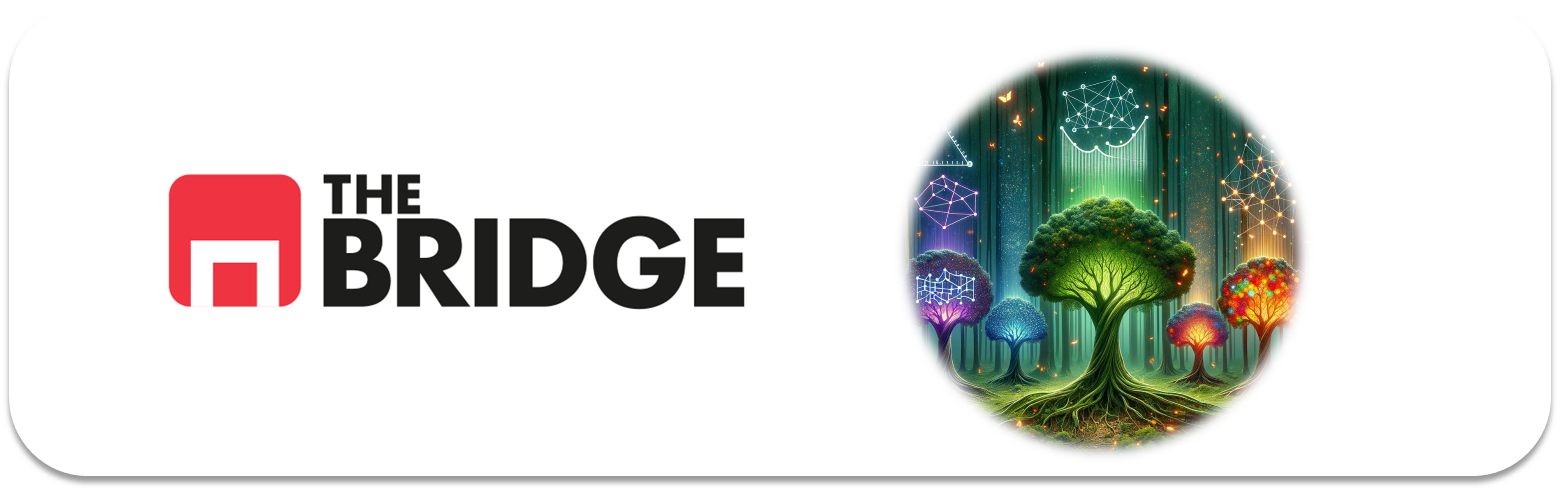

## AJUSTE DE HIPERPARAMETROS DE FORMA PRACTICA

En Machine Learning, la mayoría de los modelos tienen hiperparámetros que deben ajustarse para conseguir mejores predicciones. 

Por ejemplo, en el modelo de **Elastic Net**, teníamos la siguiente función de error:

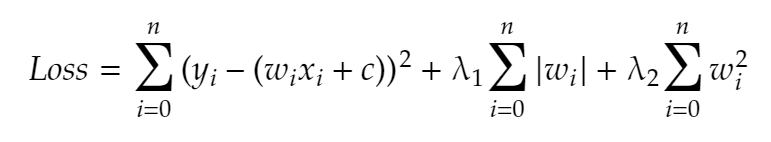

donde hay dos parámetros $\lambda_1$ y $\lambda_2$ que debemos optimizar para que el modelo ofrezca los mejores resultados posibles.

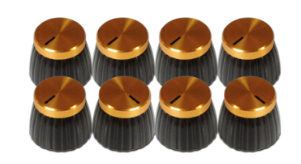


¿Por qué se llaman hiperparámetros y no parámetros? La diferencia es que los hiperparámetros hay que fijarlos antes de entrenar, mientras que los parámetros son aquellos que se ajustan en el entrenamiento. En el caso de Elastic Net, los hiperparámetros serían $\lambda_1$ y $\lambda_2$ mientras que los parámetros serían $w_0$, $w_1$, $w_2$... 

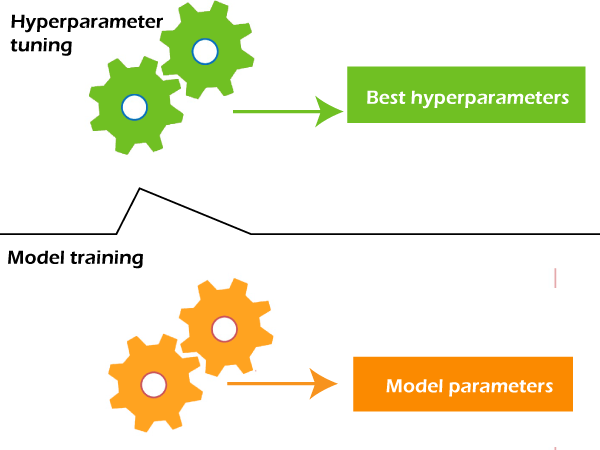

Los dos métodos más utilizados para optimizar hiperparámetros son **Random Search** y **Grid Search**. Ambas técnicas se aplican con el método de **Cross Validation**. 

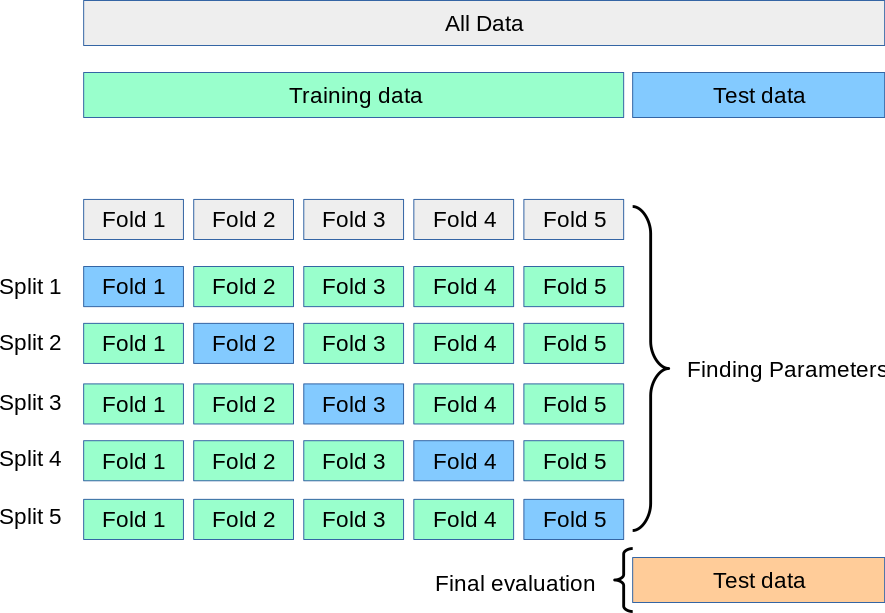

## Random Search
Como su propio nombre indica, utiliza combinaciones aleatorias de los hiperparámetros. Esto implica que no se van a probar todos los posibles valores, sino algunos muestreados de forma aleatoria. En primer lugar, se divide el dominio de hiperparámetros en un grid. Después, se seleccionan combinaciones aleatorias hasta llegar a un número máximo de iteraciones, quedándose con la mejor combinación de todas las evaluadas. 

Esta opción es recomendable cuando tenemos muchos hiperparámetros con muchos posibles valores 
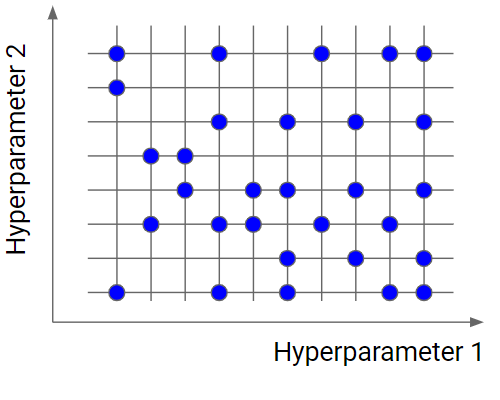

In [ ]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
import numpy as np

In [ ]:
X, y = load_diabetes(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                   random_state=42)

In [ ]:
param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0,1,0.01)
}

elastic = ElasticNet()

random_search = RandomizedSearchCV(elastic, # El modelo que quiero entrenar
                                   param_grid, # El grid de parámetros
                                   random_state=1, # Semilla
                                   n_iter=100, # Nº de iteraciones del random search
                                   cv=5, # Folds del cross validation
                                   scoring="neg_root_mean_squared_error", # Métrica que quiero optimizar
                                   n_jobs = -1 # Paralelizar
                                  )

random_search.fit(X_train, y_train)

In [ ]:
# Mejores parámetros del modelo
random_search.best_params_

In [ ]:
# Mejor score (R2)
random_search.best_score_**2

In [ ]:
# random_search.best_estimator_ contiene el mejor modelo

In [ ]:
random_search.best_estimator_.coef_

In [ ]:
random_search.best_estimator_.score(X_test, y_test)

In [ ]:
# Es equivalente a hacer esto:
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.0001, l1_ratio=0.01)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", mean_squared_error(y_train, model.predict(X_train), squared = False))
print(model.score(X_test, y_test))
print("RMSE_test", mean_squared_error(y_test, model.predict(X_test), squared = False))




In [ ]:
# Compruebo que los coeficientes coinciden con el best_estimator_
model.coef_

¿Funciona mejor que una regresión lineal sin regularización?

In [ ]:
from sklearn.linear_model import LinearRegression
diabetes_model = LinearRegression()
diabetes_model.fit(X_train, y_train)
print(diabetes_model.score(X_train,y_train))
print("RMSE", mean_squared_error(y_train, diabetes_model.predict(X_train), squared = False))
print(diabetes_model.score(X_test, y_test))
print("RMSE", mean_squared_error(y_test, diabetes_model.predict(X_test), squared = False))


***

## Grid Search
Este método prueba todas las combinaciones del grid y evalúa el modelo para cada combinación, también usando cross-validation para cada una. 
Es más lento que Random Search, ya que prueba todas las posibles combinaciones. La ventaja es que te aseguras haber encontrado la mejor de todas al finalizar el proceso, lo que no te garantizaba Random Search. 

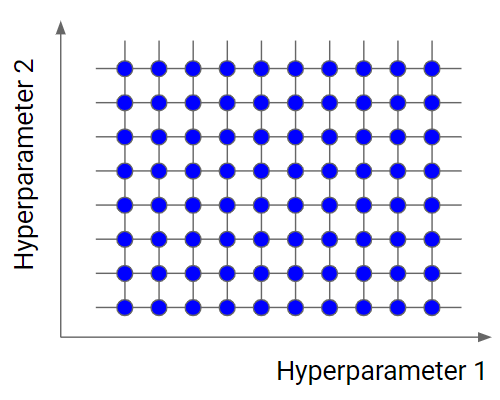

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'alpha': [1e-10, 1e-4, 1e-2, 1, 5, 10, 20, 40],
    'l1_ratio': np.arange(0, 1, 0.01)
}

elastic = ElasticNet()

grid_search = GridSearchCV(elastic,
                           param_grid,
                           cv=5,
                           scoring='r2',
                           n_jobs=-1
                          )

grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
grid_search.best_score_

In [ ]:
# R2 en test
grid_search.best_estimator_.score(X_test, y_test)

In [ ]:
# Es equivalente a hacer esto:
from sklearn.metrics import mean_squared_error

model = ElasticNet(alpha=0.01, l1_ratio=0.97)
model.fit(X_train, y_train)
print(model.score(X_train,y_train))
print("RMSE_train", mean_squared_error(y_train, model.predict(X_train), squared = False))
print(model.score(X_test, y_test))
print("RMSE_test", mean_squared_error(y_test, model.predict(X_test), squared = False))


Hemos obtenido el mejor resultado con Grid Search, ya que ha evaluado todas las posibles combinaciones, quedándose con la mejor.

## Bayesian Search
Existe un tercer método para ajustar los hiperparámetros del modelo: la optimización bayesiana, que utiliza métodos probabilísticos para elegir y probar la siguiente combinación de hiperparámetros. Con esta estrategia, se consigue que la búsqueda se vaya redirigiendo en cada iteración hacia las regiones de mayor interés. 

El objetivo final es reducir el número de combinaciones de hiperparámetros con las que se evalúa el modelo, eligiendo únicamente los mejores candidatos. La ventaja frente a las otras estrategias mencionadas es el ahorro de tiempo cuando el espacio de búsqueda es muy amplio o la evaluación del modelo es muy lenta.

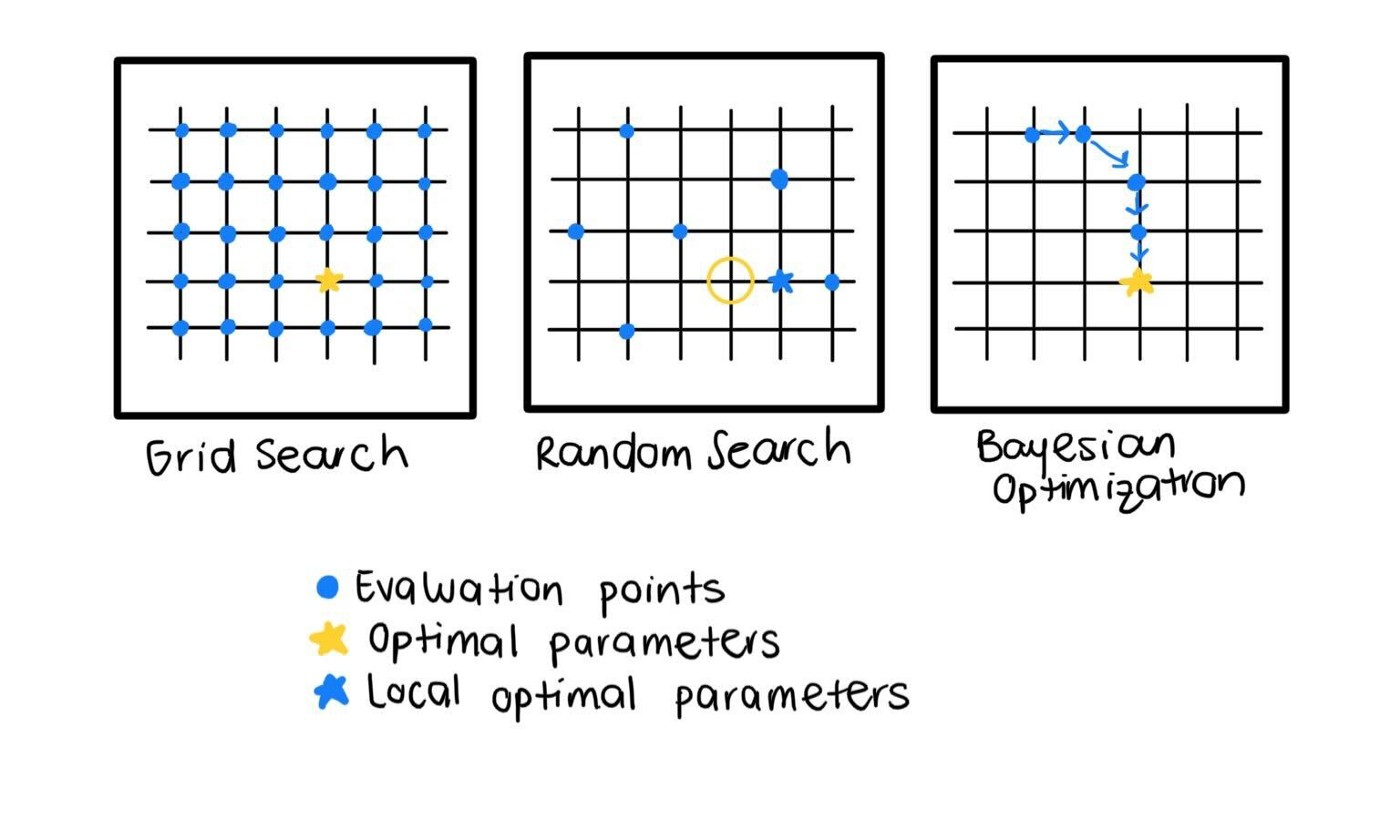

La librería Hyperopt nos permite aplicar la optimización bayesiana

In [ ]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from sklearn.model_selection import cross_val_score

In [ ]:
def hyperopt_train_test(params, scoring = "r2"):
    model = ElasticNet(**params)
    return cross_val_score(model, X_train, y_train, 
                           cv=5, scoring= scoring).mean() # Aquí la métrica es r2 pero podemos poner la que queramos de las admitidas por la validación cruzada de sklearn


# Defininmos el "grid" (hiperparámetros y rango de valores)
space = {
    'alpha': hp.uniform('alpha', 0.0001, 1.0),
    'l1_ratio': hp.uniform('l1_ratio', 0.0001, 1.0)
}

def f(params):
    r2 = hyperopt_train_test(params)
    return {'loss':-r2, 'status': STATUS_OK}

trials = Trials()
best = fmin(f, space, algo=tpe.suggest, max_evals=100, trials=trials)

In [ ]:
best # Esto nos devuelve la combinación optima encontrada 

In [ ]:
model_bayes = ElasticNet(alpha=best['alpha'], l1_ratio=best['l1_ratio'])
model_bayes.fit(X_train, y_train)
model_bayes.score(X_test, y_test)

Más información sobre los espacios de búsqueda de hyperopt: http://hyperopt.github.io/hyperopt/getting-started/search_spaces/